<img src="../img/htw-logo.png" width=150>


**I758 Wissens- und KI-basierte Systeme**

# Klassifikation mit kNN
Quelle: IBM Introduction to Machine Learning Specialization ([Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01))
 / Anpassungen CK
 

<font color="green"><b>KLAUSURTAUGLICH.</b></font>
Dieses Notebook gehört zu den fünf Notebooks, die Sie für die Klausur einreichen können. Bei vollständiger und korrekter Bearbeitung **erhalten Sie Punkte für die Abgabe, die zu Ihrer Klausur addiert werden.**

***

### Virtuelle Environments

**Hinweis:**:  In diesem Tutorial werden einige neue Bibliotheken wie z.B. die Visualisierungs-Bibliothek `seaborn` gebraucht. Mit ganz viel Glück sind diese Bibliotheken alle schon in Ihrem lokalen Environment installiert. Falls nicht, wird es Zeit, einmal die [Dokumentation von conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) zu studieren.

Legen Sie mit conda eine neue virtuelle Umgebung mit (zum Beispiel mit dem Namen `06-class` an. Installieren Sie in dieser Umgebung die folgenden Pakete:
   
```
   pip install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
```

Stellen Sie diese Umgebung in Ihrem Jupyter Notebook als Python-Compiler ein und arbeiten Sie erst dann mit diesem Notebook weiter!

***

In dieser Übung lernen Sie das K-Nearest-Neighbor-Modell (KNN) kennen und üben es. KNN ist ein unkompliziertes, aber sehr effektives Modell, das sowohl für Klassifizierungs- als auch für Regressionsaufgaben verwendet werden kann. Wenn der Merkmalsraum nicht sehr groß ist, kann KNN ein gut interpretierbares Modell sein, da Sie anhand der nächsten Nachbarn erklären und verstehen können, wie eine Vorhersage getroffen wird.

Wir werden einen Tumorprobendatensatz verwenden, der Labortestergebnisse zu Tumorproben enthält. Ziel ist die Klassifizierung, ob ein Tumor bösartig (Krebs) oder gutartig ist. Daher handelt es sich um eine typische binäre Klassifizierungsaufgabe.

### Ziele
Nach Abschluss dieser Übung sollten Sie folgende Fähigkeiten und Kenntnisse haben:
* Trainining von KNN-Modellen mit verschiedenen Nachbar-Hyperparametern
* Bewertung von Modellen für Klassifizierungsaufgaben
* Modell-Optiomierung durch Finden eines optimalen Hyperparameters

In [15]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Define a random seed to reproduce any random process
rs = 123

In [3]:
# Ignore any deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

### Laden und untersuchen Sie den Tumorprobendatensatz

Wir laden zunächst den Datensatz „tumor.csv“ als Pandas-Dataframe:

In [4]:
# Read datast in csv format from online source
# dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/tumor.csv"
## exactly the same file, but local:
dataset_url = "./data/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

Wie sieht der Tabellenkopf aus?

In [5]:
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Was können wir über die Spalten erfahren?

In [6]:
tumor_df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

Jede Beobachtung in diesem Datensatz enthält Labortestergebnisse zu einer Tumorprobe, beispielsweise Klumpen oder Formen. Basierend auf diesen Labortestergebnissen oder -merkmalen möchten wir ein Klassifizierungsmodell erstellen, um vorherzusagen, ob diese Tumorprobe bösartig (Krebs) oder gutartig ist. Die Zielvariable `y` wird in der Spalte `Class` angegeben.

Teilen wir die Daten in Input  `X` und Output `y` auf:


In [7]:
X = tumor_df.iloc[:, :-1]
y = tumor_df.iloc[:, -1:]

Wir schauen uns die Werte in `X` an:


In [8]:
X.describe()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Wie wir der obigen Zellenausgabe entnehmen können, sind alle Merkmale numerisch und liegen im Bereich zwischen 1 und 10. Dies ist sehr praktisch, da wir die Merkmalswerte nicht skalieren müssen, da sie bereits im gleichen Bereich liegen.

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> 
Erstellen Sie einen Bar Chart, der Ihnen anzeigt, wie viele Tumore gutartig sind (y = 0) und wieviele krankhaft (y = 1). 
</div>

Tipp: Pandas bietet Ihnen dafür die `value_counts` - Funktion. Für einen Dataframe `df` können Sie außerdem mit `df.plot.bar()` einen Barchart plotten. Sie sollten auf ungefähr 65% gutartige Tumore kommen. 


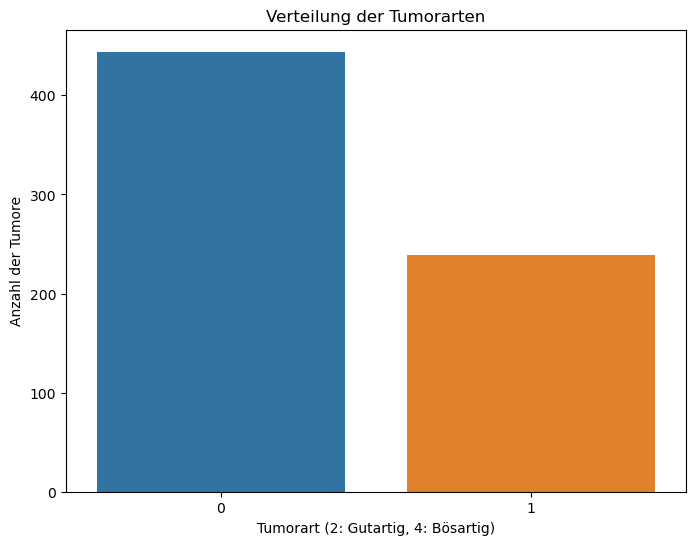

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
dataset_url = "./data/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

# Bar Chart erstellen
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=tumor_df)
plt.title('Verteilung der Tumorarten')
plt.xlabel('Tumorart (2: Gutartig, 4: Bösartig)')
plt.ylabel('Anzahl der Tumore')
plt.show()


### Trainings- und Testdatensätze verarbeiten und aufteilen

In [ ]:
# Split 80% as training dataset
# and 20% as testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

### Trainieren und bewerten Sie einen KNN-Klassifikator mit K=2

Das Training eines KNN-Klassifikators ist dem Training anderer Klassifikatoren in „sklearn“ sehr ähnlich. Wir müssen zunächst ein `KNeighborsClassifier`-Objekt definieren. Hier verwenden wir das Argument `n_neighbors=2`, um anzugeben, wie viele Nachbarn für die Vorhersage verwendet werden, und behalten andere Argumente als Standardwerte bei.

In [ ]:
# Define a KNN classifier with `n_neighbors=2`
knn_model = KNeighborsClassifier(n_neighbors=2)

Dann können wir das Modell mit `X_train` und `y_train` trainieren und verwenden die `ravel()`-Methode, um den Dataframe `y_train` in einen Vektor umzuwandeln.

In [ ]:
knn_model.fit(X_train, y_train.values.ravel())

Wir machen Vorhersagen auf  `X_test`:


In [ ]:
preds = knn_model.predict(X_test)

Um die Modellqualität im Detail zu verstehen, zeichnen wir eine Confusion Matrix:

In [ ]:
# Plot confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', annot_kws={"size": 10, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Prediction', fontsize=15);
ax.set_xlabel('Ground Truth', fontsize=15)

Um den KNN-Klassifikator auszuwerten, stellen wir eine vordefinierte Methode zur Verfügung, um die häufig verwendeten Bewertungsmetriken wie Genauigkeit, Rückruf, Präzision, f1score usw. basierend auf den wahren Klassen im `y_test` und den Modellvorhersagen zurückzugeben.

In [ ]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [ ]:
evaluate_metrics(y_test, preds)

Wir können sehen, dass der Tumorprobendatensatz eine hervorragende Klassifizierungsleistung aufweist. Dies bedeutet, dass das KNN-Modell Krebstumoren effektiv erkennen kann. Als nächstes sind Sie an der Reihe, eine andere Anzahl von Nachbarn auszuprobieren, um zu sehen, ob wir eine noch bessere Leistung erzielen könnten.

### Verbessern Sie das Modell

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> 
Verbessern Sie das Modell, indem Sie einen weiteren kNN-Classifier trainieren, diesmal jedoch mit k=5.
</div>

Definieren Sie zunächst einen KNN-Klassifikator mit der Klasse KNeighborsClassifier:

{'accuracy': 0.948905109489051,
 'recall': 0.896551724137931,
 'precision': 0.9811320754716981,
 'f1score': 0.9369369369369369}

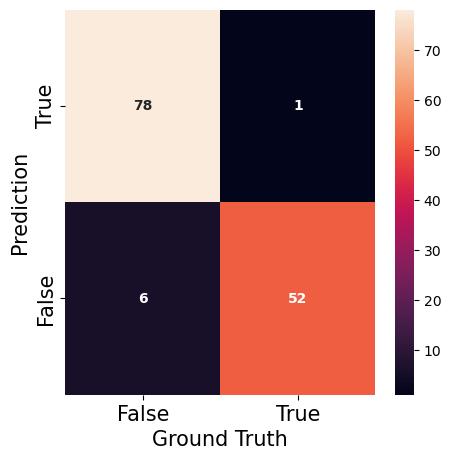

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

dataset_url = "./data/tumor.csv"
tumor_df = pd.read_csv(dataset_url)
X = tumor_df.drop(columns=['Class'])
y = tumor_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn_model_5 = KNeighborsClassifier(n_neighbors=5)
knn_model_5.fit(X_train, y_train.values.ravel())
preds_5 = knn_model_5.predict(X_test)

sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix(y_test, preds_5), annot=True, fmt='d', annot_kws={"size": 10, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Prediction', fontsize=15);
ax.set_xlabel('Ground Truth', fontsize=15)

def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

evaluate_metrics(y_test, preds_5)

Jetzt trainieren Sie das Modell mit  `X_train` und `y_train`:


In [9]:
knn_model_5 = KNeighborsClassifier(n_neighbors=5)
knn_model_5.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

Machen Sie Vorhersagen auf  `X_test` und evaluieren Sie mit  `evaluate_metrics()` auf `y_test` und `preds`:


In [7]:
preds_5 = knn_model_5.predict(X_test)

evaluation_results = evaluate_metrics(y_test, preds_5)
print("Evaluation Metrics:")
print("Accuracy:", evaluation_results['accuracy'])
print("Recall:", evaluation_results['recall'])
print("Precision:", evaluation_results['precision'])
print("F1 Score:", evaluation_results['f1score'])

Evaluation Metrics:
Accuracy: 0.948905109489051
Recall: 0.896551724137931
Precision: 0.9811320754716981
F1 Score: 0.9369369369369369


### Finden Sie das beste Modell

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> 
Verbessern Sie das Modell noch weiter, indem Sie den besten Wert für K finden.
</div>

Hier könnten wir K von 1 bis 50 ausprobieren und den aggregierten `f1score` für jedes k in einer Liste speichern.

In [11]:
# Try K from 1 to 50
max_k = 50
# Create an empty list to store f1score for each k
f1_scores = []
for k_value in range(1, max_k+1):
    knn_model = KNeighborsClassifier(n_neighbors=k_value)
    knn_model.fit(X_train, y_train.values.ravel())
    preds = knn_model.predict(X_test)
    metrics = evaluate_metrics(y_test, preds)
    f1_scores.append(metrics['f1score'])

Dann trainieren wir 50 KNN-Klassifikatoren mit K im Bereich von 1 bis 50.
Vervollständigen Sie den folgenden Code:

In [13]:
from sklearn.metrics import f1_score

f1_scores = []

for k_value in range(1, max_k+1):
    knn_model = KNeighborsClassifier(n_neighbors=k_value)
    knn_model.fit(X_train, y_train.values.ravel())
    preds = knn_model.predict(X_test)
    f1 = f1_score(y_test, preds)
    f1_scores.append((k_value, round(f1, 4)))
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
f1_results.set_index('K')

,F1 Score
K,
1,0.9273
2,0.8952
3,0.9369
4,0.9174
5,0.9369
6,0.9358
7,0.9464
8,0.9464
9,0.9464


Dies ist eine lange Liste und unterscheidet sich von der Analyse. Lassen Sie uns die Liste also mithilfe eines Liniendiagramms visualisieren.

Text(0.5, 1.0, 'KNN F1 Score')

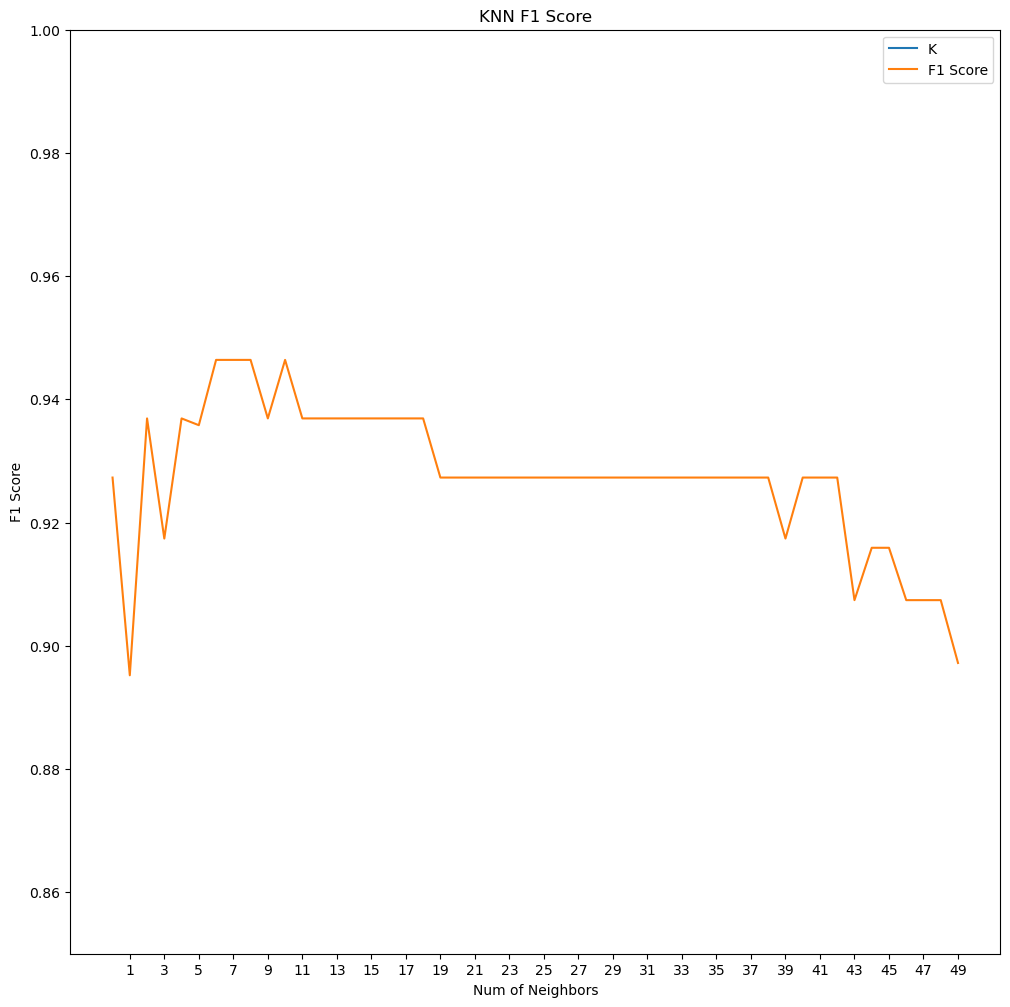

In [14]:
# Plot F1 results
ax = f1_results.plot(figsize=(12, 12))
ax.set(xlabel='Num of Neighbors', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.ylim((0.85, 1))
plt.title('KNN F1 Score')

<div class="alert alert-block alert-success">
<b>Arbeitsauftrag:</b> 
Welches K ist das beste? Welchen F1-Score können Sie damit erreichen?
</div>

Der beste K Wert liegt ungefähr bei 7. Damit kann ein F1-Score von ca.0,945 erreicht werden.